In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
data_dir = os.getcwd()+"/Neural_data/CIFAR10/"

In [3]:
sys.argv = []

In [4]:
sys.argv.append(data_dir+"train.csv")
sys.argv.append(data_dir+"test_X.csv")
sys.argv.append(data_dir+"weightfile.txt")
sys.argv.append(data_dir+"param.txt")

In [5]:
train = pd.read_csv(sys.argv[0],header=None)
test  = pd.read_csv(sys.argv[1],header=None)
train_class = train.iloc[:,-1].values
classes = pd.get_dummies(train[1024],prefix="class_")
train = pd.concat([train.iloc[:,:-1],classes],axis=1)

In [6]:
def initialiseWeights(layer):
    weights = []
    bias = []
    for i in range(1,len(layer)):
        weights.append((np.random.rand(layer[i-1]*layer[i]).reshape(layer[i],layer[i-1])-0.5))
        bias.append((np.random.rand(layer[i]).reshape(layer[i],1)-0.5))
    return (weights,bias)    

In [7]:
def normaliseFeatures(X_train):
    return (X_train-np.mean(X_train,axis=0))/255;

In [8]:
def sigmoid(z):
    return 1/(1+np.exp((-1)*z))
def sigmoid_der(z):
    s = sigmoid(z)
    return s*(1-s)

In [9]:
def tanh(z):
    return (2/(1+np.exp((-2)*z)))-1
def tanhder(z):
    t = tanh(z)
    return 1-t*t;

In [10]:
def relu(z):
    return np.where(z>0,z,0)
def reluder(z):
    z[z>0]=1
    z[z<0]=0
    return z

In [11]:
def softmax(z):
    z = np.exp(z)
    return z/np.sum(z,axis=0)

In [12]:
def softplus(z):
    return np.log(1+np.exp(z))
def softplusder(z):
    return 1/(1+np.exp((-1)*z))

In [28]:
def feedforward(weights,bias,X_train):
    a_layer = []
    z_layer = []
    a_layer.append(X_train.T)
    z_layer.append(0)
    for i in range(0,len(layer)-2):
        z_layer.append(np.matmul(weights[i],a_layer[i])+bias[i])
#         a_layer.append(sigmoid(z_layer[i+1]))
        a_layer.append(softplus(z_layer[i+1]))
#         a_layer.append(relu(z_layer[i+1]))
#         a_layer.append(tanh(z_layer[i+1]))
    z_layer.append(np.matmul(weights[-1],a_layer[-1])+bias[-1])
    a_layer.append(softmax(z_layer[-1]))    
    return (a_layer,z_layer)    

In [29]:
def backpropagate(weights,bias,a_layer,z_layer,X_train,Y_train,iteration,reg):
    regul = 1 - (reg*learningRate/Y_train.shape[0])
    new_weights = []
    new_bias = []
    layer_index = len(a_layer)-1
    delta = (a_layer[-1]-Y_train.T)/Y_train.shape[0]
    new_weights.append(np.subtract(regul*weights[layer_index-1] ,np.multiply((learningRate/iteration),np.matmul(delta,a_layer[layer_index-1].T))))
    b = np.sum(delta,axis=1)
    new_bias.append(np.subtract(regul*bias[layer_index-1],np.multiply((learningRate/iteration),b.reshape(b.shape[0],1))))
    layer_index-=1
    while(layer_index>0):
        # delta = np.matmul(weights[layer_index].T,delta)*sigmoid_der(z_layer[layer_index])
        delta = np.matmul(weights[layer_index].T,delta)*reluder(z_layer[layer_index])
        # delta = np.matmul(weights[layer_index].T,delta)*tanhder(z_layer[layer_index])
        new_weights.append(np.subtract(regul*weights[layer_index-1] ,np.multiply((learningRate/iteration),np.matmul(delta,a_layer[layer_index-1].T))))
        b = np.sum(delta,axis=1)
        new_bias.append(np.subtract(regul*bias[layer_index-1],np.multiply((learningRate/iteration),b.reshape(b.shape[0],1))))
        layer_index-=1
    new_bias.reverse()
    new_weights.reverse()
    return (new_weights,new_bias)

In [15]:
def error(Y_pred,Y_actual):
    return (-1)*np.sum(Y_actual.T*np.log(Y_pred))/Y_pred.shape[0]

In [16]:
def hot_encode(Y_pred,Y_actual):
    Y_pred = Y_pred.T  
    Y_actual = Y_actual.T
    maxVal = np.max(Y_pred,axis=1).reshape(Y_pred.shape[0],1) 
    Y_pred = Y_pred-maxVal
    Y_pred[Y_pred==0]=1
    Y_pred[Y_pred<0]=0
    d = np.sum(Y_pred*Y_actual)
    return d/Y_actual.shape[0]

In [17]:
test.shape

(5000, 1025)

In [24]:
X_train = normaliseFeatures(train.iloc[:-2000,:-10].values)
Y_train = train.iloc[:-2000,-10:].values
X_test = normaliseFeatures(train.iloc[-2000:,:-10].values)
Y_test = train.iloc[-2000:,-10:].values
print(X_train.shape,Y_train.shape)
with open(sys.argv[3]) as f:
    param = f.read().split("\n")
    learningType = int(param[0])
    learningRate = float(param[1])
    maxIteration = int(param[2])
    batchSize = int(param[3])
    layer = list(map(int,param[4].split(" ")))
    layer.insert(0,X_train.shape[1])
    layer.append(Y_train.shape[1])
# learningType = 2
# learningRate = float(0.5)
# maxIteration = int(1000)
# batchSize = int(100)
# layer = [300 , 150, 90]
# layer.insert(0,X_train.shape[1])
# layer.append(Y_train.shape[1])
print(learningType,learningRate,maxIteration,batchSize,layer)    

(18000, 1024) (18000, 10)
2 0.3 2000 80 [1024, 100, 10]


In [30]:
X_train = normaliseFeatures(train.iloc[:-2000,:-10].values)
Y_train = train.iloc[:-2000,-10:].values
X_test = normaliseFeatures(train.iloc[-2000:,:-10].values)
Y_test = train.iloc[-2000:,-10:].values

k = batchSize
l = X_train.shape[0]
weights, bias = initialiseWeights(layer)
error_value = []
o = maxIteration
batches = l/k
accuracy_test = []
accuracy_train = []
for i in range(o):
    print(i,end="\r",flush=True)
    start_index = int(k*(i%batches))
    end_index = int(k*((i%batches)+1))
    a_layer , z_layer = feedforward(weights,bias,X_train[start_index:end_index,:])
    Y_pred , z = feedforward(weights,bias,X_test)
    accuracy_test.append(hot_encode(Y_pred[-1],Y_test.T))
#     Y_pred , z = feedforward(weights,bias,X_train)
#     accuracy_train.append(hot_encode(Y_pred[-1],Y_train.T))
    error_value.append(error(a_layer[-1],Y_train[start_index:end_index,:]))
    weights, bias = backpropagate(weights,bias,a_layer,z_layer,X_train[start_index:end_index,:],Y_train[start_index:end_index,:],np.sqrt(1),0.21)        


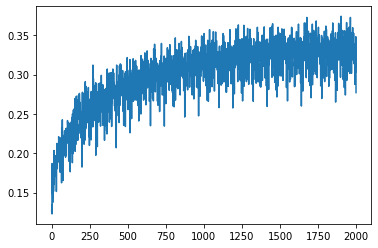

In [31]:
plt.plot(range(len(accuracy_test)),accuracy_test)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

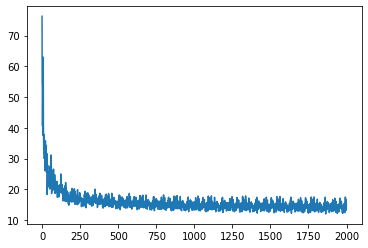

In [32]:
plt.plot(range(len(error_value)),error_value)
plt.show



In [149]:
a_layer , z_layer = feedforward(weights,bias,X_test)
hot_encode(a_layer[-1],Y_test.T)

0.281

In [84]:
a_layer

[array([[-0.3939549 , -0.36258235,  0.0060451 , ...,  0.19820196,
          0.03349608,  0.13545686],
        [-0.38130588, -0.3420902 ,  0.00300784, ...,  0.20300784,
          0.02261569,  0.13241961],
        [-0.36989608, -0.33068039,  0.00657451, ...,  0.20657451,
          0.02226078,  0.13598627],
        ...,
        [-0.39805686, -0.13923333, -0.28433137, ...,  0.1195902 ,
         -0.11570392, -0.33923333],
        [-0.39736078, -0.2208902 , -0.27971373, ...,  0.11244314,
         -0.11500784, -0.36598824],
        [-0.39674118, -0.3065451 , -0.27909412, ...,  0.11698431,
         -0.1183098 , -0.40850588]]),
 array([[4.15432036, 2.84479519, 0.68705433, ..., 0.        , 3.12904423,
         4.09157835],
        [1.53789541, 2.21018845, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.51333312, 0.        , 0.        , ..., 0.75488497, 0.        ,
         0.16283053],
        ...,
        [0.        , 0.        , 1.08502337, ..., 1.70942646, 2.35456211

In [83]:
a_layer , z_layer = feedforward(weights,bias,X_test)

# a = np.array([ np.where(out==np.amax(out))[0][0] for out in a_layer[-1].T])
# j=0
# for i in range(a.shape[0]):
#     if(a[i]==train_class[i+18000]):
#         j+=1
# print(j/a.shape[0])
# plt.hist(a)
# plt.show()
# plt.plot(range(len(error_value)),error_value)
# plt.show()

In [ ]:
a_layer , z_layer = feedforward(weights,bias,X_test)
a = np.array([ np.where(out==np.amax(out))[0][0] for out in a_layer[-1].T])
j=0
for i in range(a.shape[0]):
    if(a[i]==train_class[i]):
        j+=1
print(j/a.shape[0])

In [ ]:
a_layer , z_layer = feedforward(weights,bias,X_train)
a = np.array([ np.where(out==np.amax(out))[0][0]+1 for out in a_layer[-1].T])
j=0
for i in range(a.shape[0]):
    if(a[i]==train_class[i]):
        j+=1
j/a.shape[0]

In [ ]:
plt.hist(a)
plt.show()

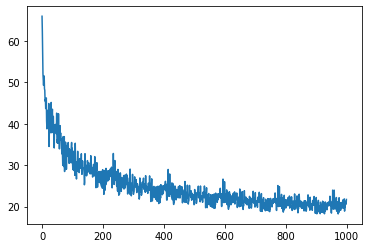

In [27]:
plt.plot(range(len(error_value)),error_value)
plt.show()

In [ ]:
a.tolist()

In [ ]:
a = np.array([])
for m in range(len(bias)):
    a = np.concatenate((a,bias[m].flatten(),weights[m].flatten('F')))
np.savetxt("weigth.txt",a)

In [ ]:
a_layer[-1].shape

In [ ]:
error_der = -Y_train.T/(a_layer[-1]*Y_train.shape[0])
error_der.shape

In [ ]:
s = softmax(z_layer[-1])
(s*(1-s)).shape

In [ ]:
a_laye

In [ ]:
a_layer[2][a_layer[2]>0.5]=1
a_layer[2][a_layer[2]<0.5]=0

In [ ]:
a_layer[2].tolist()[0]

In [ ]:
pd.DataFrame({'pred':a_layer[2].tolist(),'actual':Y_train.tolist()})

In [ ]:
np.sum(a_layer[2],Y_train,axis=0)

In [ ]:
def backpropagate(weights,bias,a_layer,z_layer,X_train,Y_train):
    new_weights = []
    new_bias = []
    error_der = (a_layer[2]-Y_train)/((1-a_layer[2])*a_layer[2]*X_train.shape[0])
    s = sigmoid(z_layer[2])
    sigmaDer = (s*(1-s))
    deltaL = error_der*sigmaDer
    new_weights.append(np.subtract(weights[1] ,np.multiply(learningRate,np.matmul(deltaL,a_layer[1].T))))
    b = np.sum(deltaL,axis=1)
    new_bias.append(np.subtract(bias[1],np.multiply(learningRate,b.reshape(b.shape[0],1))))
    s = sigmoid(z_layer[1])
    sigmaDer = (s*(1-s))
    deltal3 = np.matmul(weights[1].T,deltaL)*sigmaDer
    new_weights.append(np.subtract(weights[0] ,np.multiply(learningRate,np.matmul(deltal3,a_layer[0].T))))
    b = np.sum(deltal3,axis=1)
    new_bias.append(np.subtract(bias[0],np.multiply(learningRate,b.reshape(b.shape[0],1))))
    new_bias.reverse()
    new_weights.reverse()
    return (new_weights,new_bias)

In [ ]:

k = batchSize
l = X_train.shape[0]
maxIteration =30
weights, bias = initialiseWeights(layer)
error = []
for i in range(maxIteration):
    start_index = int((k)*(i%6))
    end_index = int((k)*((i%6)+1))
    a_layer , z_layer = feedforward(weights,bias,X_train[start_index:end_index,:])
    weights, bias = backpropagate(weights,bias,a_layer,z_layer,X_train[start_index:end_index,:],Y_train[start_index:end_index])
# a_layer , z_layer = feedforward(weights,bias,X_train)
# error.append(np.linalg.norm(np.subtract(a_layer[2],Y_train))/300)   
for i in range(len(bias)):
    print(bias[i].flatten())
print("errr")
for i in range(len(weights)):
    print(weights[i].flatten())

In [ ]:
a_layer , z_layer = feedforward(weights,bias,X_train[0:50])


In [ ]:
new_weights = []
new_bias = []
# error_der = (a_layer[2]-Y_train)/((1-a_layer[2])*a_layer[2]*X_train.shape[0])
# s = sigmoid(z_layer[2])
# sigmaDer = (s*(1-s))
# deltaL = error_der*sigmaDer
error_der = a_layer
# print(deltaL.shape)
# new_weights.append(np.subtract(weights[1] ,np.multiply(learningRate,np.matmul(deltaL,a_layer[1].T))))
# b = np.sum(deltaL,axis=1)
# new_bias.append(b.reshape(b.shape[0],1))

In [ ]:
weights, bias = initialiseWeights(layer)

In [ ]:

k = batchSize
l = X_train.shape[0]
maxIteration =1
weights, bias = initialiseWeights(layer)
error = []
for j in range(maxIteration):
#     print(j,end="\r",flush=True)
    for i in range(int(l/k)):
        start_index = int((k)*i)
        end_index = int((k)*(i+1))
        a_layer , z_layer = feedforward(weights,bias,X_train[start_index:end_index,:])
        weights, bias = backpropagate(weights,bias,a_layer,z_layer,X_train[start_index:end_index,:],Y_train[start_index:end_index])
#         for k in range(len(bias)):
#             print(bias[k].flatten(),weights[k].flatten())
#         print("hi this is akshay\n\n\n")
    a_layer , z_layer = feedforward(weights,bias,X_train)
    error.append(np.linalg.norm(np.subtract(a_layer[2],Y_train))/300)    

In [ ]:
plt.plot(range(len(error)),error)
plt.show()

In [ ]:
a_layer , z_layer = feedforward(weights,bias,X_train)


In [ ]:
fa_layer[2]+Y_train

In [ ]:
weights, bias = initialiseWeights(layer)
a_layer , z_layer = feedforward(weights,bias,X_train[0:50])
weights, bias = backpropagate(weights,bias,a_layer,z_layer,X_train[0:50],Y_train[0:50])

In [ ]:
for i in range(len(bias)):
    print(bias[i].flatten())
print("errr")
for i in range(len(weights)):
    print(weights[i].flatten())

In [ ]:
am = [10 , 20 ,30]
40 in am

In [ ]:
new_weights = []
new_bias = []
error_der = (a_layer[2]-Y_train)/((1-a_layer[2])*a_layer[2]*X_train.shape[0])
s = sigmoid(z_layer[2])
sigmaDer = (s*(1-s))
deltaL = error_der*sigmaDer
print(deltaL.shape)
new_weights.append(np.subtract(weights[1] ,np.multiply(learningRate,np.matmul(deltaL,a_layer[1].T))))
b = np.sum(deltaL,axis=1)
new_bias.append(b.reshape(b.shape[0],1))

In [ ]:
# print(new_weights[-1])
s = sigmoid(z_layer[1])
sigmaDer = (s*(1-s))
deltal3 = np.matmul(weights[1].T,deltaL)*sigmaDer
new_weights.append(np.subtract(weights[0] ,np.multiply(learningRate,np.matmul(deltal3,a_layer[0].T))))
b = np.sum(deltal3,axis=1)
new_bias.append(b.reshape(b.shape[0],1))
# print(new_weights[0].shape,new_weights[1].shape)
# print(np.sum(deltaL),deltal3)

In [ ]:
new_bias.reverse()
new_weights.reverse()
print(new_bias,"\n",new_weights)
weights = new_weights
bias = new_bias

In [ ]:
s = sigmoid(z_layer[1])
sigmaDer = (s*(1-s))
deltal3 = np.matmul(weights[1].T,deltaL)*sigmaDer
print(weights[1].shape,deltaL.shape,sigmaDer.shape)
new_bias.append(np.sum(deltal3,axis=1))

In [ ]:
print(new_weights)

In [ ]:
np.matmul(weights[1].T,deltaL)

In [ ]:
new_weights = []
new_bias = []
error_der = (a_layer[4]-Y_train)/((1-a_layer[4])*a_layer[4]*X_train.shape[0])
s = sigmoid(z_layer[4])
sigmaDer = (s*(1-s))
deltaL = error_der*sigmaDer
print(deltaL.shape)
new_weights.append(np.subtract(weights[3] ,np.multiply(learningRate,np.matmul(deltaL,a_layer[3].T))))
print(new_weights[-1])

In [ ]:
s = sigmoid(z_layer[3])
sigmaDer = (s*(1-s))
deltal3 = np.matmul(weights[3].T,deltaL)*sigmaDer
new_weights.append(np.subtract(weights[2] ,np.multiply(learningRate,np.matmul(deltal3,a_layer[2].T))))
print(new_weights[-1])
# print(weights[2].shape,deltal3.shape,a_layer[2].T.shape)

In [ ]:
s = sigmoid(z_layer[2])
sigmaDer = (s*(1-s))
deltal2 = np.matmul(weights[2].T,deltal3)*sigmaDer
new_weights.append(np.subtract(weights[1] ,np.multiply(learningRate,np.matmul(deltal2,a_layer[1].T))))
print(new_weights[-1])
# print(weights[2].shape,deltal3.shape,a_layer[2].T.shape)

In [ ]:
s = sigmoid(z_layer[1])
sigmaDer = (s*(1-s))
deltal1 = np.matmul(weights[1].T,deltal2)*sigmaDer
new_weights.append(np.subtract(weights[0] ,np.multiply(learningRate,np.matmul(deltal1,a_layer[0].T))))
print(new_weights[-1])

In [ ]:
deltal3.shape

In [ ]:
np.negative(deltaL)


In [ ]:
y0 = X_train.T
z1 = np.matmul(weights[0],y0)+bias[0]
y1 = sigmoid(z1)
z2 = np.matmul(weights[1],y1)+bias[1]
y2 = sigmoid(z2)
z3 = np.matmul(weights[2],y2)+bias[2]
y3 = sigmoid(z3)
z4 = np.matmul(weights[3],y3)+bias[3]
y4 = sigmoid(z4)

In [ ]:
print(y0.shape,y1.shape,y2.shape,y3.shape,y4.shape)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
train = pd.read_csv(sys.argv[1],header=None)
test  = pd.read_csv(sys.argv[2],header=None)
classes = pd.get_dummies(train[1024],prefix="class_")
train = pd.concat([train.iloc[:,:-1],classes],axis=1)
def initialiseWeights(layer):
    weights = []
    bias = []
    for i in range(1,len(layer)):
        weights.append((np.random.rand(layer[i-1]*layer[i]).reshape(layer[i],layer[i-1])-0.5))
        bias.append((np.random.rand(layer[i]).reshape(layer[i],1)-0.5))
    return (weights,bias)    
def normaliseFeatures(X_train):
    return (X_train-np.mean(X_train,axis=0))/255;
X_train = normaliseFeatures(train.iloc[:,:-10].values)
Y_train = train.iloc[:,-10:].values
X_test  = test.iloc[:,:-1].values
print(X_train.shape,Y_train.shape,X_test.shape)
learningType = 2
learningRate = float(0.01)
maxIteration = int(1000)
batchSize = int(100)
layer = [10]
layer.insert(0,X_train.shape[1])
layer.append(Y_train.shape[1])
print(learningType,learningRate,maxIteration,batchSize,layer)
def sigmoid(z):
    return 1/(1+np.exp((-1)*z))
def sigmoid_der(z):
    s = sigmoid(z)
    return s*(1-s)
def tanh(z):
    return (2/(1+np.exp((-2)*z)))-1
def tanhder(z):
    t = tanh(z)
    return 1-t*t;
def relu(z):
    return np.where(z>0,z,0)
def reluder(z):
    z[z>0]=1
    z[z<0]=0
    return z
def softmax(z):
    z = np.exp(z)
    return z/np.sum(z,axis=0)    
def feedforward(weights,bias,X_train):
    a_layer = []
    z_layer = []
    a_layer.append(X_train.T)
    z_layer.append(0)
    for i in range(0,len(layer)-2):
        z_layer.append(np.matmul(weights[i],a_layer[i])+bias[i])
#         a_layer.append(sigmoid(z_layer[i+1]))
        a_layer.append(relu(z_layer[i+1]))
#         a_layer.append(tanh(z_layer[i+1]))
    z_layer.append(np.matmul(weights[-1],a_layer[-1])+bias[-1])
    a_layer.append(softmax(z_layer[-1]))    
    return (a_layer,z_layer)    
def backpropagate(weights,bias,a_layer,z_layer,X_train,Y_train,iteration):
    new_weights = []
    new_bias = []
    layer_index = len(a_layer)-1
    delta = (a_layer[-1]-Y_train.T)/Y_train.shape[0]
    new_weights.append(np.subtract(weights[layer_index-1] ,np.multiply((learningRate/iteration),np.matmul(delta,a_layer[layer_index-1].T))))
    b = np.sum(delta,axis=1)
    new_bias.append(np.subtract(bias[layer_index-1],np.multiply((learningRate/iteration),b.reshape(b.shape[0],1))))
    layer_index-=1
    while(layer_index>0):
#         delta = np.matmul(weights[layer_index].T,delta)*sigmoid_der(z_layer[layer_index])
        delta = np.matmul(weights[layer_index].T,delta)*reluder(z_layer[layer_index])
#         delta = np.matmul(weights[layer_index].T,delta)*tanhder(z_layer[layer_index])
        new_weights.append(np.subtract(weights[layer_index-1] ,np.multiply((learningRate/iteration),np.matmul(delta,a_layer[layer_index-1].T))))
        b = np.sum(delta,axis=1)
        new_bias.append(np.subtract(bias[layer_index-1],np.multiply((learningRate/iteration),b.reshape(b.shape[0],1))))
        layer_index-=1
    new_bias.reverse()
    new_weights.reverse()
    return (new_weights,new_bias)    
k = batchSize
l = X_train.shape[0]
weights, bias = initialiseWeights(layer)
error_value = []
o = maxIteration
batches = l/k
for i in range(o):
    start_index = int(k*(i%batches))
    end_index = int(k*((i%batches)+1))
    a_layer , z_layer = feedforward(weights,bias,X_train[start_index:end_index,:])
    # error_value.append(error(a_layer[-1],Y_train[start_index:end_index,:]))
    weights, bias = backpropagate(weights,bias,a_layer,z_layer,X_train[start_index:end_index,:],Y_train[start_index:end_index,:],np.sqrt(1))        
    
a_layer , z_layer = feedforward(weights,bias,X_test)
a = np.array([ np.where(out==np.amax(out))[0][0] for out in a_layer[-1].T])
np.savetxt(sys.argv[3],a)    